In [1]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from src.common.globals import G
from src.common.plots import Visualize as V
from src.data.get_data import CSVsLoader
from src.common.logs import setup_logging, log_model_info
from src.features.build_features import FeatureEngineering as FE

from src.models_service.models_service import TensorflowDataPreparation as TFDataPrep
from src.models_service.models_service import TensorflowModelService as TFModelService
from src.models_service.errors import ErrorsCalculation as ErrorCalc


logger = setup_logging(logger_name=__name__,
                        console_level=logging.INFO, 
                        log_file_level=logging.INFO)

DATA_DIR_PROCESSED = G.processed_daily_full_dir

config = {
    'AV': {
        'key': '',
        'ticker': 'VGT',
    },
    'data': {
        'test_size': 0.05,
    },
    'model': {
        'name': 'VGT_LSTM_trend20_W20_SBS1_B128_E1500_P42625_2023_11_19__01_30',
        'type': 'trend',
        'trend_prediction_window': 20,
    }
    ,
}

2023-11-20 05:55:29.940759: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 05:55:29.940836: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 05:55:29.940871: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 05:55:29.948859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# -----------------------------Data----------------------------------------
df = CSVsLoader(ticker=config['AV']['ticker'], logger=logger, directory=DATA_DIR_PROCESSED)
df = FE.create_features(df, logger)
df = FE.create_slope_column(df, logger, slope_window=config['model']['trend_prediction_window'])
df_train, df_test = TFDataPrep.split_train_test(df, config['data']['test_size'], logger)

price = df_test['Adj Close']

_, df_test, y_column = TFDataPrep(config=config).choose_y(df_train, df_test, logger)

df_test_X = df_test.drop(columns=[y_column])
df_test_X = FE.rename_shifted_columns(df_test_X)
df_test_y = df_test[y_column]

#------------------------Load the model if necessary--------------------------
model_scaler_name = config['model']['name']

model = TFModelService.load_model(model_name=model_scaler_name, logger=logger)
scalers_X = TFModelService.load_scalers(model_name=model_scaler_name, logger=logger)
window_size = TFModelService.get_window_size_from_model_name(model._name)
pred_trend_window = config['model']['trend_prediction_window']

2023-11-20 05:55:31 - get_data - INFO - Loaded "../P7-Trading-Bot/data/03_processed/daily_full". Number data points 4965. From "2004-01-30 00:00:00" to "2023-10-19 00:00:00"
2023-11-20 05:55:31 - build_features - INFO - --------------------create_features() - shift(-1)--------------------
2023-11-20 05:55:31 - build_features - INFO - df.shape: (4964, 5)


2023-11-20 05:55:31 - build_features - INFO - df.columns: Index(['Open', 'Adj Close', 'Volume', 'high-low variance', 'Tomorrow'], dtype='object')
2023-11-20 05:55:34 - build_features - INFO - --------------------FE.create_slope_column()--------------------
2023-11-20 05:55:34 - build_features - INFO - df.shape: (4945, 6)
2023-11-20 05:55:34 - build_features - INFO - df.columns: Index(['Open', 'Adj Close', 'Volume', 'high-low variance', 'Tomorrow',
       'slope_20'],
      dtype='object')
2023-11-20 05:55:34 - models_service - INFO - df_train.shape: (4698, 6), df_test.shape: (247, 6)
2023-11-20 05:55:34 - models_service - INFO - Last record in df_train:
Open                 3.215500e+02
Adj Close            3.149712e+02
Volume               2.315876e+06
high-low variance    2.963769e+00
Tomorrow             3.186156e+02
slope_20            -1.813974e-01
Name: 2022-09-27 00:00:00, dtype: float64
2023-11-20 05:55:34 - models_service - INFO - Last record in df_test:
Open                  

     10/Unknown - 1s 6ms/step  

2023-11-20 05:55:36.288688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


228/228 [==============================] - 2s 6ms/step


2023-11-20 05:55:37.678530: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7511776722930145119
2023-11-20 05:55:37 - plots - INFO - Plot "Predictions VGT_LSTM_trend_20_W20_SBS1_B128_E1500_P42625_2023_11_19__01_30-VGT_LSTM_trend_20_W20_SBS1_B128_E1500_P42625_2023_11_19__01_30.png" saved to "/workspaces/P7-Trading-Bot/figures/Predictions VGT_LSTM_trend_20_W20_SBS1_B128_E1500_P42625_2023_11_19__01_30-VGT_LSTM_trend_20_W20_SBS1_B128_E1500_P42625_2023_11_19__01_30.png"


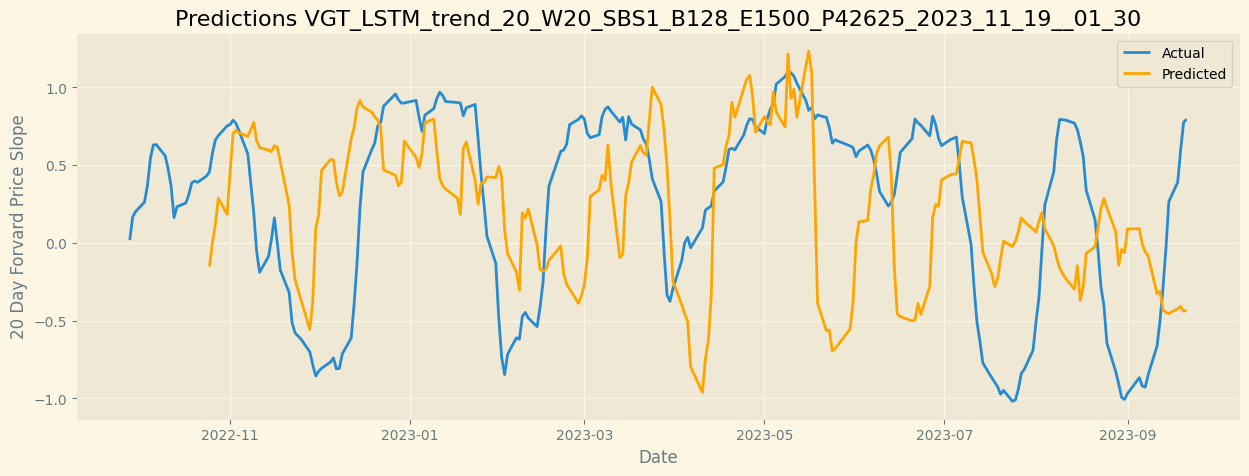

'/workspaces/P7-Trading-Bot/figures/Predictions VGT_LSTM_trend_20_W20_SBS1_B128_E1500_P42625_2023_11_19__01_30-VGT_LSTM_trend_20_W20_SBS1_B128_E1500_P42625_2023_11_19__01_30.png'

In [3]:
# -----------------------------Predictions-----------------------------------
results = TFModelService.model_forecast(model=model, 
                                        df=df_test_X,
                                        window_size=window_size,
                                        scalers=scalers_X,
                                        verbose=False)


V.plot_series(  x=(df_test_y.index, df_test_y.index[window_size-1:]), 
                y=(df_test_y, results),
                model_name=model._name,
                signal = False,
                title=f'Predictions {model._name}',
                xlabel='Date',
                ylabel='20 Day Forvard Price Slope',
                legend=['Actual', 'Predicted'],
                show=True)

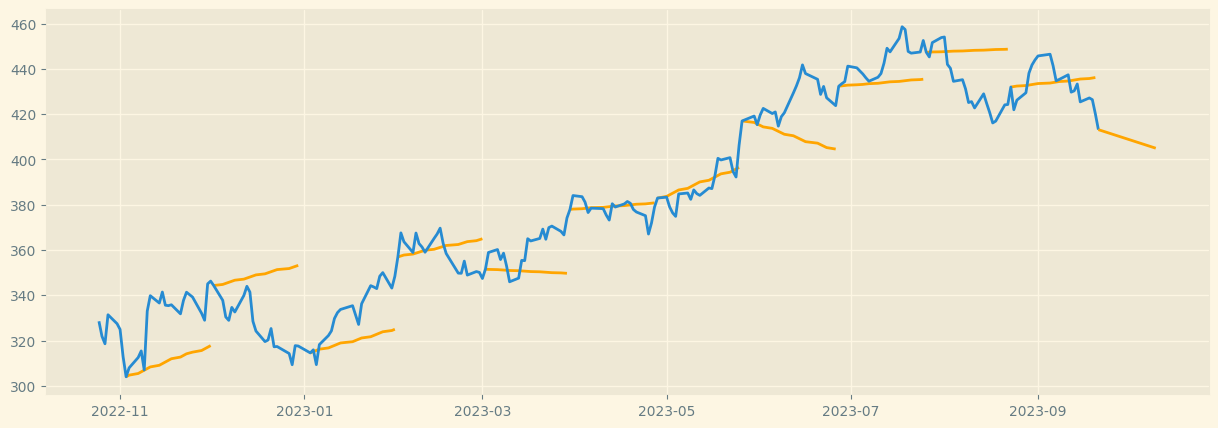

In [4]:
V.plot_trends(results, price, df_test_y, window_size, pred_trend_window)

In [5]:
# # -----------------------Calculate Errors----------------------------------
df_test_y_no_window = df_test_y.iloc[window_size-1:]      # actual values without window size in the beginning

naive_forecast = ErrorCalc.get_naive_forecast(df).loc[df_test_y_no_window.index] 
rmse, mae, mape, mase = ErrorCalc.calc_errors(df_test_y_no_window, results, naive_forecast, config['model']['type'])
ErrorCalc.save_errors_to_table(model._name, {'rmse': rmse, 'mae': mae, 'mape': mape, 'mase': mase})

2023-11-20 05:55:38 - errors - INFO - Test RMSE:   0.687
2023-11-20 05:55:38 - errors - INFO - Test MAE :   0.581
2023-11-20 05:55:38 - errors - INFO - Errors saved to for VGT_LSTM_trend_20_W20_SBS1_B128_E1500_P42625_2023_11_19__01_30 model to "logs/models_table.csv" file.


/workspaces/P7-Trading-Bot/models_trained
                                               model            timestamp  \
0  VGT_LSTM_trend_20_W20_SBS1_B128_E1500_P42625_2...  2023-11-20 05:55:38   

    rmse    mae  mape  mase  Saved  
0  0.687  0.581   NaN   NaN  False  
